In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from matplotlib import pyplot as plt

### Set Device ###

In [2]:
device = torch.device("cpu")
if torch.cuda.is_available():
    print("CUDA is available!")
    device = torch.device("cuda")
    print("GPU:", torch.cuda.get_device_name(0))

### Define Conditional Variational Autoencoder ###

In [3]:
import math

def convert_labels_to_one_hot(c, num_classes):
    one_hot = torch.zeros((len(c), num_classes))  # initialize one-hot tensor with zeros
    for i, label in enumerate(c):
        one_hot[i, label] = 1
    return one_hot


first_out_channels = 32
second_out_channels=64
class MultiLabel_cVAE(nn.Module):
    def __init__(self, width, height, h_dim, z_dim, num_classes, input_channels, needs_one_hot=True, ):
        super(MultiLabel_cVAE, self).__init__()
        
        self.num_classes = num_classes
        self.width = width
        self.height = height
        self.width_percentage = width/(width+height)

        
        # there are 2 max poolings which each half the sqrt dim of x.dim
        self.size_of_flattened = int(height/4) * int(width/4) * second_out_channels

        self.needs_one_hot = needs_one_hot
                
        self.encoderLayersCNN = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=first_out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=first_out_channels, out_channels=second_out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        self.encoderLayersLinear = nn.Sequential(
            nn.Linear(in_features=self.size_of_flattened + self.num_classes, out_features=h_dim),
            nn.ReLU())
        

        self.mu_sample_layer = nn.Linear(in_features=h_dim, out_features=z_dim)
        self.log_var_sample_layer = nn.Linear(in_features=h_dim, out_features=z_dim)
        
        # decoder part
        self.decoderLayersPt1 = nn.Sequential(
            nn.Linear(z_dim+self.num_classes, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, self.size_of_flattened)
        )
        self.decoderLayersPt2 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=second_out_channels, out_channels=first_out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=first_out_channels, out_channels=input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def encoder(self, x, c_one_hot):
        h = self.encoderLayersCNN(x)
        concat = torch.cat([h, c_one_hot], dim=1)
        h = self.encoderLayersLinear(concat)
        return self.mu_sample_layer(h), self.log_var_sample_layer(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z, c_one_hot):
        zc = torch.cat([z, c_one_hot], dim=1)
        x = self.decoderLayersPt1(zc)
        pixelsComponent = x.shape[1] / second_out_channels
        width_component = int(self.width/4)
        height_component = int(self.height/4)
        
        #width_component = int(pixelsComponent * self.width_percentage)
        #height_component = int(pixelsComponent-width_component)
        x = x.view(-1, second_out_channels, width_component, height_component)
        x = self.decoderLayersPt2(x)
        return x
    
    def forward(self, x, c):
        c_onehot = c
        if self.needs_one_hot:
            c_onehot = torch.nn.functional.one_hot(c, num_classes=self.num_classes)
        # flatten
        mu, log_var = self.encoder(x, c_onehot)
        z = self.sampling(mu, log_var)
        return self.decoder(z, c_onehot), mu, log_var
    
    def generate(self, c):
        print(c.size())
        z = torch.randn(len(c), 2).to(device)
        c_onehot = c
        if self.needs_one_hot:
            c_onehot = torch.nn.functional.one_hot(c, num_classes=10).to(device)
        return self.decoder(z, c_onehot)

### Define Loss ###

In [4]:
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    #print the shapes
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

### Define Train and Test Methods ###

In [5]:
def train(model, epoch, train_loader, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data, labels)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

def test(model, test_loader):
    model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)
            recon_batch, mu, log_var = model(data, labels)
            
            # sum up batch loss
            test_loss += loss_function(recon_batch, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

### Load MNIST Digit Dataset ###

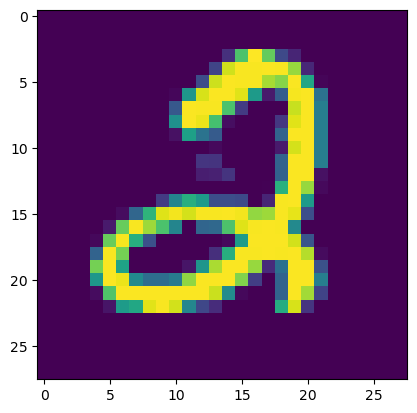

784


In [6]:
dataset = 'dataset'

batch_size = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root=dataset, train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root=dataset, train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Read a sample image from the dataset
sample_image, _ = next(iter(train_loader))

# Derive the input dimension dynamically
x_dim = sample_image.shape[-1] * sample_image.shape[-2]

# Display the sample image
plt.imshow(sample_image[0].permute(1, 2, 0))
plt.show()
print(x_dim)

In [7]:
# build model
vae = MultiLabel_cVAE(width=28, height=28, h_dim=512,z_dim=2, num_classes=10, input_channels=1, needs_one_hot=True)
vae = vae.to(device)

In [8]:
# define optimizer
optimizer = optim.Adam(vae.parameters())

In [9]:
for epoch in range(1, 5):
    train(vae, epoch, train_loader, optimizer)
    test(vae, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 590.882070
Train Epoch: 1 [1000/60000 (2%)]	Loss: 342.283906
Train Epoch: 1 [2000/60000 (3%)]	Loss: 227.905449
Train Epoch: 1 [3000/60000 (5%)]	Loss: 225.396523
Train Epoch: 1 [4000/60000 (7%)]	Loss: 202.569609
Train Epoch: 1 [5000/60000 (8%)]	Loss: 200.175508
Train Epoch: 1 [6000/60000 (10%)]	Loss: 190.972617
Train Epoch: 1 [7000/60000 (12%)]	Loss: 187.972402
Train Epoch: 1 [8000/60000 (13%)]	Loss: 185.768203
Train Epoch: 1 [9000/60000 (15%)]	Loss: 177.577070
Train Epoch: 1 [10000/60000 (17%)]	Loss: 173.404004
Train Epoch: 1 [11000/60000 (18%)]	Loss: 169.991816
Train Epoch: 1 [12000/60000 (20%)]	Loss: 172.871680
Train Epoch: 1 [13000/60000 (22%)]	Loss: 171.210957
Train Epoch: 1 [14000/60000 (23%)]	Loss: 161.504961
Train Epoch: 1 [15000/60000 (25%)]	Loss: 164.595117
Train Epoch: 1 [16000/60000 (27%)]	Loss: 158.177695
Train Epoch: 1 [17000/60000 (28%)]	Loss: 155.193184
Train Epoch: 1 [18000/60000 (30%)]	Loss: 152.621670
Train Epoch: 1 [19000/60000 (32

### Generate Samples ###

torch.Size([100])


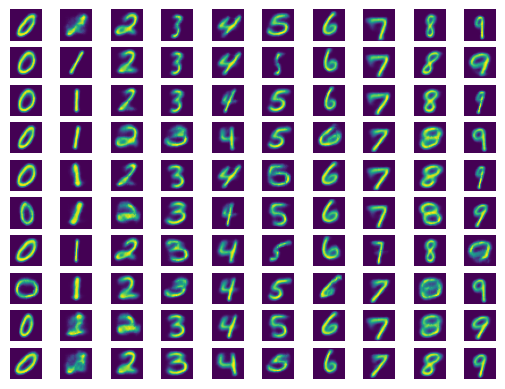

In [10]:
with torch.no_grad():
    c = torch.tensor([i % 10 for i in range(100)])
    generated_images = vae.generate(c)
    
    for (i, img) in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        plt.imshow(img.view(28, 28).cpu().numpy())
        plt.axis('off')


# Load CelebA Dataset #

In [11]:
#Import CelebA Dataset
celeb_train_dataset = datasets.CelebA(root=dataset, split='train', download=False, transform=transforms.ToTensor())
celeb_test_dataset = datasets.CelebA(root=dataset, split='test', download=False, transform=transforms.ToTensor())

In [12]:
def nearest_divisible_by_4(num):
    return int(num/4)*4
batch_size = 100
attributes = celeb_train_dataset.attr_names[:-1]
print(attributes)

# Compute the new image size that is divisible by 4
img_size = celeb_train_dataset[0][0].size()

img_width = int(nearest_divisible_by_4(img_size[1]))
img_height = int(nearest_divisible_by_4(img_size[2]))
print("Image Height: ", img_height)
print("Image Width: ", img_width)


# Resize datasets to maintain as much information as possible while still being divisible by 4
transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor()
])

celeb_train_dataset.transform = transform
celeb_test_dataset.transform = transform


# Data Loader (Input Pipeline)
celeb_train_loader = torch.utils.data.DataLoader(dataset=celeb_train_dataset, batch_size=batch_size, shuffle=True)
celeb_test_loader = torch.utils.data.DataLoader(dataset=celeb_test_dataset, batch_size=batch_size, shuffle=False)

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
Image Height:  176
Image Width:  216


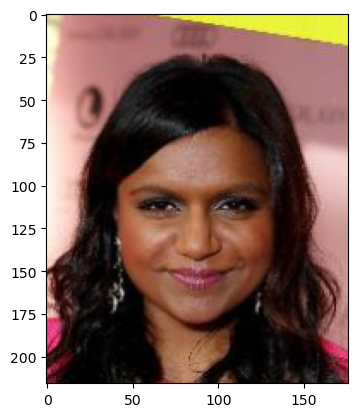

Features shape torch.Size([100, 40])
Num Classes:  40
Arched_Eyebrows
Bags_Under_Eyes
Big_Nose
Black_Hair
Heavy_Makeup
High_Cheekbones
No_Beard
Rosy_Cheeks
Smiling
Wavy_Hair
Wearing_Earrings
Wearing_Lipstick
Young


In [13]:
# View a sample image from the dataset
sample_image, features = next(iter(celeb_train_loader))
plt.show(plt.imshow(sample_image[0].permute(1, 2, 0)))

print("Features shape " + str(features.shape))

#Print heihgt and width of the image
image_height = sample_image.shape[-2]
image_width = sample_image.shape[-1]

num_classes = len(attributes)
print("Num Classes: ", num_classes)

for (i, feature) in enumerate(features[0]):
    if (feature == 1):
        print(attributes[i])


### Train VAE on CelebA Dataset ###

In [14]:
torch.cuda.empty_cache()

celeb_vae = MultiLabel_cVAE(width=img_width, height=img_height, h_dim=256,z_dim=2, num_classes=num_classes, input_channels=3, needs_one_hot=False)
celeb_vae = celeb_vae.to(device)

#Run one sample through the model
sample_image, features = next(iter(celeb_train_loader))
sample_image = sample_image.to(device)
features = features.to(device)
recon_batch, mu, log_var = celeb_vae(sample_image, features)
print("Recon Batch Shape: ", recon_batch.shape)

Recon Batch Shape:  torch.Size([100, 3, 216, 176])


In [17]:
# define optimizer
optimizer = optim.Adam(celeb_vae.parameters(), lr=.001)

for epoch in range(1, 2):
    train(celeb_vae, epoch, celeb_train_loader, optimizer)
    test(celeb_vae, celeb_test_loader)

Train Epoch: 1 [0/162770 (0%)]	Loss: 79090.400000
Train Epoch: 1 [1000/162770 (1%)]	Loss: 73289.725000
Train Epoch: 1 [2000/162770 (1%)]	Loss: 72932.495000
Train Epoch: 1 [3000/162770 (2%)]	Loss: 69702.635000
Train Epoch: 1 [4000/162770 (2%)]	Loss: 69254.905000
Train Epoch: 1 [5000/162770 (3%)]	Loss: 68136.445000
Train Epoch: 1 [6000/162770 (4%)]	Loss: 69296.330000
Train Epoch: 1 [7000/162770 (4%)]	Loss: 68104.165000
Train Epoch: 1 [8000/162770 (5%)]	Loss: 66923.880000
Train Epoch: 1 [9000/162770 (6%)]	Loss: 66528.720000
Train Epoch: 1 [10000/162770 (6%)]	Loss: 68232.715000
Train Epoch: 1 [11000/162770 (7%)]	Loss: 67262.220000
Train Epoch: 1 [12000/162770 (7%)]	Loss: 68018.065000
Train Epoch: 1 [13000/162770 (8%)]	Loss: 66081.070000
Train Epoch: 1 [14000/162770 (9%)]	Loss: 66758.905000
Train Epoch: 1 [15000/162770 (9%)]	Loss: 67679.240000
Train Epoch: 1 [16000/162770 (10%)]	Loss: 67570.320000
Train Epoch: 1 [17000/162770 (10%)]	Loss: 66986.390000
Train Epoch: 1 [18000/162770 (11%)]	Los

KeyboardInterrupt: 

### Generate Samples ###

torch.Size([1, 40])
torch.Size([1, 40])
torch.Size([1, 40])
torch.Size([1, 40])
torch.Size([1, 40])
torch.Size([1, 40])
torch.Size([1, 40])
torch.Size([1, 40])
torch.Size([1, 40])
torch.Size([1, 40])


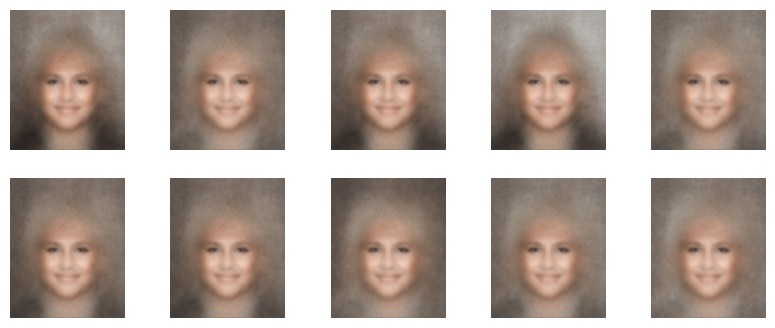

In [18]:
import random
def generate_images(model, num_images, tgt_attributes=None):
    """
    Generates num_images images from the given model with the specified attribute labels.

    Args:
        model (MultiLabel_cVAE): The model to generate images from.
        num_images (int): The number of images to generate.
        attributes (dict): A dictionary of attribute labels to condition the generated images on. The keys of the dictionary
                           should be the attribute names (strings) and the values should be binary values indicating the
                           presence (1) or absence (0) of the attribute. If an attribute value is set to None, a random
                           value is generated for that attribute.
        celeba_dataset (CelebA): The CelebA dataset used to extract the attribute names. If not provided, the attribute
                                 names are assumed to be the standard CelebA attribute names.

    Returns:
        A tensor of shape (num_images, 3, H, W) representing the generated images.
    """
    # Load the attribute names from the CelebA dataset if not provided

    # Create a tensor to hold the generated images
    
    images = torch.zeros((num_images, 3, model.width, model.height))

    # Generate the specified number of images
    for i in range(num_images):
        # Generate a random value for each attribute that is None
        if tgt_attributes is not None:
            for attr in attributes:
                if tgt_attributes[attr] is None:
                    tgt_attributes[attr] = random.randint(0, 1)

        # Convert the attributes dictionary to a tensor
        if tgt_attributes is None:
            c = torch.tensor([torch.randint(0,2) for _ in range(num_images)])
        else:
            c = torch.tensor([tgt_attributes[attr] for attr in tgt_attributes]).unsqueeze(0)
        
        c = c.to(device)
        # Generate an image with the specified attribute labels
        image = model.generate(c)

        # Add the image to the tensor
        images[i] = image.squeeze()

    return images
celeb_vae.eval()
num_images = 10

tgt_attributes = {'5_o_Clock_Shadow': None, 'Arched_Eyebrows': None, 'Attractive': None, 'Bags_Under_Eyes': None, 'Bald': 1, 'Bangs': None, 'Big_Lips': None, 'Big_Nose': None, 'Black_Hair': None, 'Blond_Hair': None, 'Blurry': None, 'Brown_Hair': None, 'Bushy_Eyebrows': None, 'Chubby': None, 'Double_Chin': None, 'Eyeglasses': None, 'Goatee': None, 'Gray_Hair': None, 'Heavy_Makeup': None, 'High_Cheekbones': None, 'Male': None, 'Mouth_Slightly_Open': None, 'Mustache': None, 'Narrow_Eyes': None, 'No_Beard': None, 'Oval_Face': None, 'Pale_Skin': None, 'Pointy_Nose': None, 'Receding_Hairline': None, 'Rosy_Cheeks': None, 'Sideburns': None, 'Smiling': None, 'Straight_Hair': None, 'Wavy_Hair': None, 'Wearing_Earrings': None, 'Wearing_Hat': None, 'Wearing_Lipstick': None, 'Wearing_Necklace': None, 'Wearing_Necktie': None, 'Young': None}

images = generate_images(celeb_vae, num_images, tgt_attributes)

# Display the generated images
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(num_images, 4))
for i in range(num_images):
    ax = axes[i//5, i%5]
    ax.imshow(images[i].detach().permute(1, 2, 0))
    ax.axis('off')
plt.show()


In [23]:
#Evaluate Results using Fréchet Inception Distance (FID)
from pytorch_fid import fid_score
import torchvision
import torchvision.transforms as transforms

# Store 10 train images into a folder
for i in range(10):
    train_image = (torchvision.utils.make_grid(celeb_train_dataset[i][0], nrow=1, padding=0))
    torchvision.utils.save_image(train_image, 'train_images/train_image_{}.png'.format(i))

# Save the generated images to files for fid calculation
for i in range(num_images):
    torchvision.utils.save_image(images[i], 'generated_images/generated_image_{}.png'.format(i))

# Calculate FID
fid_value = fid_score.calculate_fid_given_paths(['train_images', 'generated_images'], batch_size=10, dims=2048, device = device)
print(fid_value)


100%|██████████| 1/1 [00:06<00:00,  6.48s/it]


454.9726789799127
